# Notebook to format data from "Behavioral classification of low frequency acceleration and temperature data from a free ranging small mammal", Studd et al (2018).

Data can be found [here](https://datadryad.org/stash/dataset/doi:10.5061%2Fdryad.1s1m8r7).

Paper is [here](https://onlinelibrary.wiley.com/doi/full/10.1002/ece3.4786)

## Setup

In [1]:
# Outputs:
# formatted dataset directory
# dataset_metadata (yaml), includes
## sample_rate
## dataset_label_names (list)
## dataset_feature_names (list)
## clip_ids (list)
# clip_data (directory), includes
## data_files (multiple files)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import glob
import yaml
import scipy.signal as signal
import tqdm
import matplotlib.dates
from datetime import datetime

In [4]:
# Specify data filepaths

raw_data_dir = '/home/jupyter/behavior_data_local/data/raw/studd_squirrels'
formatted_data_dir = '/home/jupyter/behavior_data_local/data/formatted/studd_squirrels'

if not os.path.exists(formatted_data_dir):
    os.makedirs(formatted_data_dir)
    
data_fps = glob.glob(raw_data_dir + '/squirrel*s.csv')

clip_data_dir = os.path.join(formatted_data_dir, 'clip_data')
if not os.path.exists(clip_data_dir):
    os.makedirs(clip_data_dir)

In [5]:
# Dataset metadata
dataset_metadata = {}
sr = 1
dataset_metadata['sr'] = sr ## from dataset documentation
dataset_metadata['dataset_name'] = 'studd_squirrels'

In [6]:
## Data is formatted weirdly-- there is a lot of overlap in timestamps
## I need to comb through the various files and extract one of each timestamp
## Then, order by timestamp

data = pd.read_csv(data_fps[0])

for fp in data_fps[1:]:
    d = pd.read_csv(fp)
    data = data.append(d)

In [7]:
## We simplify annotations using the BEHAV column 
## see section 2.2 in their paper
##

simplify_annot_dict = {'Feed' : 'feeding',
                       'notMoving' : 'not_moving',
                       'Nest' : 'unknown', # We won't use temperature data
                       'CLIP' : 'foraging',
                       'StatMove' : 'stationary_movement',
                       'RunningMove' : 'traveling',
                       'SlowMove' : 'foraging',
                       'CCONE' : 'foraging',
                       'HorizMove' : 'traveling',
                       'VertMove' : 'traveling',
                       'DIGG' : 'foraging',
                       'OOS' : 'unknown', 
                       'STO' : 'unknown',
                       'vocal' : 'unknown', 
                       'IPOD' : 'unknown', 
                       'GRO' : 'unknown', 
                       'cache' : 'unknown', 
                       'TSV' : 'unknown', 
                       'TRAVT' : 'unknown', 
                       'CMUSH' : 'unknown'
                      }

data['label'] = data['BEHAV'].copy()
data['label'] = data['label'].map(lambda x: simplify_annot_dict[x])

In [8]:
## Check that annotations agree when a (time stamp, individual_id) pair is repeated
if False:

    times = data['TIME'].unique()
    for time in tqdm.tqdm(list(times)):
        data_at_time = data[data['TIME'] == time]
        if len(set(data_at_time['label'])) != 1 and len(set(data_at_time['ID'])) == 1:
            print(time)

In [9]:
# Clean up and keep track of datetime properly

data = data.drop_duplicates(subset = ['TIME', 'ID']).copy()

data['datetime'] = data['TIME'].map(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

data.sort_values(['ID', 'datetime'], inplace = True)
data.reset_index(inplace = True)

In [10]:
# If there is a gap in sampling, treat it as a new clip

data['clip_id'] = data['OBS'].copy()
deployment_id = 0

for i, row in tqdm.tqdm(data.iterrows(), total = len(data)):
    data.loc[i, 'clip_id']= "clip_" + str(deployment_id)
    if i<len(data)-1:
        if (data.loc[i+1, 'datetime'] - row['datetime']).total_seconds() != 1.0:
            deployment_id += 1
        elif data.loc[i+1, 'ID'] != row['ID']:
            deployment_id += 1
        else:
            pass
    else:
        pass

100%|██████████| 33883/33883 [00:33<00:00, 1012.85it/s]


Text(0.5, 1.0, 'how many samples per deployment?')

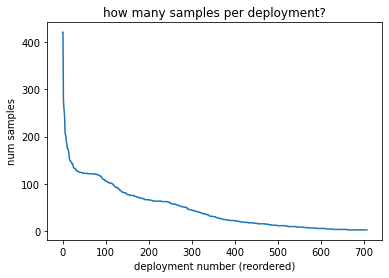

In [11]:
plt.plot(list(data['clip_id'].value_counts()))
plt.ylabel('num samples')
plt.xlabel('deployment number (reordered)')
plt.title("how many samples per deployment?")

In [12]:
# Drop deployments with fewer than 60 samples
num_samples_cutoff = 60
deployments_to_keep = list(data['clip_id'].value_counts()[data['clip_id'].value_counts() >= num_samples_cutoff].index)

data_subselected = data[data['clip_id'].isin(deployments_to_keep)].copy()
data_subselected.reset_index(inplace = True)

In [13]:
## Integer codes for individuals

clip_id_to_individual_id = {row['clip_id'] : row['ID'] for i, row in data_subselected.iterrows()}

dataset_metadata['individual_ids'] = [i for i in range(14)] # There are 14 individuals but only 13 mentioned in the paper
dataset_metadata['clip_id_to_individual_id'] = clip_id_to_individual_id

individuals = sorted({clip_id_to_individual_id[key] for key in clip_id_to_individual_id})

In [14]:
# Set up data splits by individual

test_proportion = .25
num_individuals = len(individuals)

test_num_individuals = int(test_proportion * num_individuals)

rng = np.random.default_rng(1280)
test_individuals = list(rng.choice(individuals, size = test_num_individuals, replace = False))
test_individuals.sort()

train_individuals = individuals.copy()
for i in test_individuals:
    train_individuals.remove(i)

In [15]:
# Set up clip ids 

# Clip ids
clip_ids = sorted(set(data_subselected['clip_id']))
test_clip_ids = []
train_clip_ids = []
for i, row in data_subselected.iterrows():
    clip_id = row['clip_id']
    individual = clip_id_to_individual_id[clip_id]
    train_clip_ids.append(clip_id) if individual in train_individuals else test_clip_ids.append(clip_id)
    
dataset_metadata['clip_ids'] = clip_ids
dataset_metadata['train_clip_ids'] = sorted(set(train_clip_ids))
dataset_metadata['test_clip_ids'] = sorted(set(test_clip_ids))

## Create dataset-level metadata

In [16]:
## Integer codes for specific behaviors

# list of behaviors
beh_names = {simplify_annot_dict[key] for key in simplify_annot_dict}
beh_names.remove('unknown')
beh_names = sorted(beh_names)
beh_names.insert(0, 'unknown')

dataset_metadata['label_names'] = beh_names

beh_str_to_int = {name : i for i, name in enumerate(beh_names)}
beh_int_to_str = {i : name for i, name in enumerate(beh_names)}

data_subselected['int_label'] = data_subselected['label'].map(lambda x: beh_str_to_int[x])

In [17]:
## clip_data column names

clip_column_names = ['AccX', 'AccY', 'AccZ', 'StaticAccX', 'StaticAccY', 'StaticAccZ', 'individual_id', 'label']
dataset_metadata['clip_column_names'] = clip_column_names

In [18]:
## Save off dataset level metadata

dataset_metadata_fp = os.path.join(formatted_data_dir, 'dataset_metadata.yaml')

with open(dataset_metadata_fp, 'w') as file:
    yaml.dump(dataset_metadata, file)

In [19]:
print("The dataset has %d samples" % len(data_subselected))

The dataset has 25375 samples


## Format Clip Data

In [20]:
# TYPICALLY: use butterworth filter to extract low and high frequency components
# def extract_static(series, low_cutoff_freq):
#     # extract static component
#     sos = signal.butter(10, low_cutoff_freq, 'low', fs=sr, output='sos')
#     low_passed_series = signal.sosfilt(sos, series)
#     remaining_series = series - low_passed_series
#     return low_passed_series, remaining_series
#
# For this dataset, we use the provided static components (they do not provide raw data)

In [21]:
# For each clip, create and save the data in the correct format

for clip_id in clip_ids:
    # load features
    clip_data = data_subselected[data_subselected['clip_id'] == clip_id]
    
    clip_data_np = np.array(clip_data[['X', 'Y', 'Z', 'Xs', 'Ys', 'Zs', 'ID', 'int_label']])
    
    clip_data_fp = os.path.join(clip_data_dir, clip_id + '.npy')
    np.save(clip_data_fp, clip_data_np)
    

## Check it all looks ok

In [55]:
clip_id = clip_ids[0]
clip_data_fp = os.path.join(clip_data_dir, clip_id + '.npy')
data = np.load(clip_data_fp)

In [56]:
np.shape(data)

(141, 8)

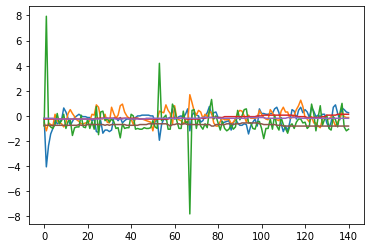

In [57]:
for i in range(np.shape(data)[1]-2):
    plt.plot(data[:, i])

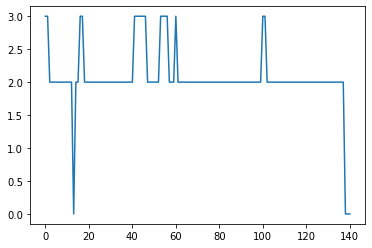

In [58]:
plt.plot(data[:, 7])

In [60]:
beh_names

['unknown',
 'feeding',
 'foraging',
 'not_moving',
 'stationary_movement',
 'traveling']